# NO Pathways
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 15 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 21 February 2020.

The objective of this tutorial is to explore the relative importance of different nitric oxide (NO) formation pathways in a laminar premixed flame. It also shows how one can multiply the rates of individual reactions in a reaction mechanism by arbitray constant values. We will use the thermodynamic properties, reaction mechanism, and transport properties that are included in gri30.cti.

The reader should be familiar with the material in the earlier chapter Notebooks before working through this Notebook.

## 1. NO formation pathways and GRI-Mech 3.0

As discussed in Chapter 5 of Turns 4th ed., several different pathways for NO formation have been identified. The key elementary reactions for each of the following four pathways are presented and discussed there:

* The Zeldovich (including extended Zeldovich), or thermal NO, mechanism

* The $N_2O$-intermediate mechanism

* The Fenimore, or prompt, mechanism

* The NNH mechanism

In most practical applications, thermal NO dominates. Thermal NO was discussed in tutorial Notebook 4_2_ODE_integration_thermal_NO, including approximations that are often invoked to arrive at simplified rate expressions.

We have used gri30.cti in many of the earlier tutorial Notebooks. [GRI-Mech 3.0](http://combustion.berkeley.edu/gri-mech/version30/text30.html)  is a widely used reaction mechanism to model natural gas combustion, including NO formation. All of the above NO formation pathways are included in GRI-Mech 3.0.

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

The reactions that involve NO can be identified as follows:

In [3]:
# count and list all of the reactions that involve NO
NO_reactions   = [i for i, r in enumerate(gas.reactions()) if 'NO' in r.reactants or 'NO' in r.products]
n_NO_reactions = len(NO_reactions)

print(n_NO_reactions,gas.n_reactions)

for i in NO_reactions:
    print(i,gas.reaction(i).equation)

40 325
177 N + NO <=> N2 + O
178 N + O2 <=> NO + O
179 N + OH <=> H + NO
181 N2O + O <=> 2 NO
185 HO2 + NO <=> NO2 + OH
186 NO + O + M <=> NO2 + M
187 NO2 + O <=> NO + O2
188 H + NO2 <=> NO + OH
189 NH + O <=> H + NO
194 NH + O2 <=> NO + OH
197 NH + NO <=> N2 + OH
198 NH + NO <=> H + N2O
207 NNH + O <=> NH + NO
211 H + NO + M <=> HNO + M
212 HNO + O <=> NO + OH
213 H + HNO <=> H2 + NO
214 HNO + OH <=> H2O + NO
215 HNO + O2 <=> HO2 + NO
221 NCO + O <=> CO + NO
223 NCO + OH <=> CO + H + NO
225 NCO + O2 <=> CO2 + NO
227 NCO + NO <=> CO + N2O
228 NCO + NO <=> CO2 + N2
243 C + NO <=> CN + O
244 C + NO <=> CO + N
245 CH + NO <=> HCN + O
246 CH + NO <=> H + NCO
247 CH + NO <=> HCO + N
248 CH2 + NO <=> H + HNCO
249 CH2 + NO <=> HCN + OH
250 CH2 + NO <=> H + HCNO
251 CH2(S) + NO <=> H + HNCO
252 CH2(S) + NO <=> HCN + OH
253 CH2(S) + NO <=> H + HCNO
254 CH3 + NO <=> H2O + HCN
255 CH3 + NO <=> H2CN + OH
257 HCNN + O <=> HCN + NO
273 HCCO + NO <=> CO + HCNO
280 CN + NO2 <=> NCO + NO
282 CO2 + N <=

So, 40 of the 325 reactions in the reaction mechanism involve NO.

The key reactions for each NO formation pathway are given in Chapter 5 of Turns 4th ed. We could search for each of those reactions as we have done for other reactions in earlier tutorial Notebooks (e.g., 4_4_Chemical_time_scales), but here the reaction indices for the key reactions involved in each pathway are specified directly. These can be found by inspection of the reaction mechanism. Recall that the reactions considered in GRI-Mech 3.0 are tabulated in Table 5.4 of Turns 4th ed., and that the reaction numbers given there are one greater than the corresponding Cantera reaction indices.

In [4]:
# create a list of the reaction indices for the reactions involved in the extended Zeldovich mechanism
Zeldo  = [177,178,179]

# create a list of the reaction indices for the reactions involved in the N2O-intermediate mechanism
N2Oint = [181,184,198]

# create a list of the reaction indices for the reactions involved in the prompt mechanism
prompt = [239,230,238,222,190,179]

# create a list of the reaction indices for the reactions involved in the NNH mechanism
NNH    = [203,207,185,188,187]

In [5]:
# print the reactions involved in the extended Zeldovich mechanism
for index in Zeldo:
    print(index,gas.reaction(index).equation)    

177 N + NO <=> N2 + O
178 N + O2 <=> NO + O
179 N + OH <=> H + NO


In [6]:
# print the reactions involved in the N2O-intermediate mechanism
for index in N2Oint:
    print(index,gas.reaction(index).equation)  

181 N2O + O <=> 2 NO
184 N2O (+M) <=> N2 + O (+M)
198 NH + NO <=> H + N2O


In [7]:
# print the reactions involved in the prompt mechanism
for index in prompt:
    print(index,gas.reaction(index).equation)  

239 CH + N2 <=> HCN + N
230 HCN + O <=> H + NCO
238 C + N2 <=> CN + N
222 H + NCO <=> CO + NH
190 H + NH <=> H2 + N
179 N + OH <=> H + NO


In [8]:
# print the reactions involved in the NNH mechanism
for index in NNH:
    print(index,gas.reaction(index).equation)  

203 NNH <=> H + N2
207 NNH + O <=> NH + NO
185 HO2 + NO <=> NO2 + OH
188 H + NO2 <=> NO + OH
187 NO2 + O <=> NO + O2


## 2. Isolate the contribution of each NO pathway in a laminar premixed flame

There are various ways in which one can formally determine the contribution of an individual reaction, or a subset of reactions in a reaction mechanism, to the total formation of a particular species. Here we simply enable or disable individual reactions in the reaction mechanism to isolate the contributions of different NO formation pathways. This approach is not strictly rigorous, as some reactions and species are involved in more than one pathway. However, it has the advantage of being straightforward, and it is sufficient to provide some insight into the relative contributions of different pathways.

Here we explore NO formation in a laminar premixed flame. We begin by defining a function to compute the structure of an adiabatic, steady, one-dimensional, laminar premixed flame following the approach that was used in tutorial Notebook 8_1_Steady_1D_laminar_premixed_flame: 

In [9]:
# define a function that computes an adiabatic, steady, 1D laminar premixed flame, and returns the laminar flame speed,
#   the NO mole fraction profile, and the temperature profile
# the final computational grid also is returned, as that can vary from one solution to another
# a new solution is started from scratch on each call to this function
# all output is suppressed (loglevel=0): the value of loglevel can be increased to see what is happening, in case
#   solution failures are encountered
def laminar_premixed_NO(gas,fuel,oxid,phi,T_u,P):
    gas.TP = T_u, P
    gas.set_equivalence_ratio(phi,fuel,oxid)
    width  = 0.015 # (m)
    flame  = ct.FreeFlame(gas,width=width)
    flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
    loglevel = 0
    flame.solve(loglevel=loglevel, auto=True)
    return flame.u[0],flame.grid,flame.X[gas.species_index('NO')],flame.T

A stoichiometric methane-air flame is simulated, with reactants at ambient temperature and pressure:

In [10]:
fuel = 'CH4'
air  = 'O2:1.0, N2:3.76'
phi  = 1.0
T_u  = 300.
P    = ct.one_atm

### 2.1 Full NO chemistry

We first compute a flame where all reactions in the reaction mechanism are considered. It may take on the order one one minute of computer time to find the steady-state solution, depending on your computer. Watch the "Kernel Busy" indicator on the toolbar. The same holds for the subsequent flame solutions.

In [11]:
# simulate a flame with full NO chemistry
sl_full,x_full,XNO_full,T_full = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)

# print some results, if desired
#sl_full,x_full,XNO_full,T_full

### 2.2 No NO chemistry

We next disable all reactions that involve NO. To do this, we use Cantera's [`set_multiplier()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.set_multiplier) attribute to set to zero the reaction rate multipliers (see attribute [`multipler()`](https://cantera.org/documentation/docs-2.4/sphinx/html/cython/kinetics.html#cantera.Kinetics.multiplier)) for all reactions that involve NO:

In [12]:
# disable all reactions that involve NO
for i in NO_reactions:
    gas.set_multiplier(0.,i)
    print(i,gas.multiplier(i))
    
# simulate a flame with no NO chemistry
sl_none,x_none,XNO_none,T_none = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)

# print some results, if desired
#sl_none,x_none,XNO_none,T_none 

177 0.0
178 0.0
179 0.0
181 0.0
185 0.0
186 0.0
187 0.0
188 0.0
189 0.0
194 0.0
197 0.0
198 0.0
207 0.0
211 0.0
212 0.0
213 0.0
214 0.0
215 0.0
221 0.0
223 0.0
225 0.0
227 0.0
228 0.0
243 0.0
244 0.0
245 0.0
246 0.0
247 0.0
248 0.0
249 0.0
250 0.0
251 0.0
252 0.0
253 0.0
254 0.0
255 0.0
257 0.0
273 0.0
280 0.0
282 0.0


### 2.3 Extended Zeldovich (thermal) NO only

To consider thermal NO only, the multipliers are set to zero for all reactions that involve NO, except for the reactions involved in the extended Zeldovich mechanism:

In [13]:
# disable all reactions that involve NO
for i in NO_reactions:
    gas.set_multiplier(0.,i)
    
# activate thermal NO reactions
for i in Zeldo:
    gas.set_multiplier(1.,i)
    print(i,gas.multiplier(i))
    
# simulate a flame with thermal NO chemistry only
sl_Zeldo,x_Zeldo,XNO_Zeldo,T_Zeldo = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)

# print some results, if desired
#sl_Zeldo,x_Zeldo,XNO_Zeldo,T_Zeldo

177 1.0
178 1.0
179 1.0


### 2.4 $N_2O$-intermediate NO only

To consider $N_2O$-intermediate NO only, the multipliers are set to zero for all reactions that involve NO, except for the reactions involved in the $N_2O$-intermediate mechanism:

In [14]:
# disable all reactions that involve NO
for i in NO_reactions:
    gas.set_multiplier(0.,i)
    
# activate N2O-intermediate NO reactions
for i in N2Oint:
    gas.set_multiplier(1.,i)
    print(i,gas.multiplier(i))
    
# simulate a flame with N2O-intermediate NO chemistry only
sl_N2Oint,x_N2Oint,XNO_N2Oint,T_N2Oint = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)

# print some results, if desired
#sl_N2Oint,x_N2Oint,XNO_N2Oint,T_N2Oint 

181 1.0
184 1.0
198 1.0


### 2.5 Prompt NO only

To consider prompt (Fenimore) NO only, the multipliers are set to zero for all reactions that involve NO, except for the reactions involved in the prompt mechanism:

In [15]:
# disable all reactions that involve NO
for i in NO_reactions:
    gas.set_multiplier(0.,i)
    
# activate prompt NO reactions
for i in prompt:
    gas.set_multiplier(1.,i)
    print(i,gas.multiplier(i))
    
# simulate a flame with prompt NO chemistry only
sl_prompt,x_prompt,XNO_prompt,T_prompt = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)
#sl_prompt,x_prompt,XNO_prompt,T_prompt 

239 1.0
230 1.0
238 1.0
222 1.0
190 1.0
179 1.0


### 2.6 NNH NO only

To consider NNH NO only, the multipliers are set to zero for all reactions that involve NO, except for the reactions involved in the NNH mechanism:

In [16]:
# disable all reactions that involve NO
for i in NO_reactions:
    gas.set_multiplier(0.,i)
    
# activate NNH NO reactions
for i in NNH:
    gas.set_multiplier(1.,i)
    print(i,gas.multiplier(i))
    
# simulate a flame with NNH NO chemistry only
sl_NNH,x_NNH,XNO_NNH,T_NNH = laminar_premixed_NO(gas,fuel,air,phi,T_u,P)
#sl_NNH,x_NNH,XNO_NNH,T_NNH 

203 1.0
207 1.0
185 1.0
188 1.0
187 1.0


### 2.7 Results and discussion

We first look at the computed laminar flame speeds and temperature profiles, then at the computed NO mole fraction profiles.

In [17]:
# print the laminar flame speeds
sl_full, sl_none, sl_Zeldo, sl_N2Oint , sl_prompt, sl_NNH

(0.3819354261894096,
 0.38231843424019574,
 0.3823949632996181,
 0.3823175040123472,
 0.3823913997028071,
 0.3823029496787126)

The computed laminar flame speeds for all six flames are the same to at least three significant figures. The NO chemistry does not have a significant influence on this global quantity, as expected.

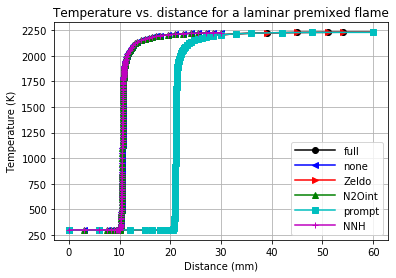

In [18]:
# plot steady-state temperature profiles
fig, ax = plt.subplots()
ax.plot(x_full*1000.,   T_full,   'k-o', label='full'  )
ax.plot(x_none*1000.,   T_none,   'b-<', label='none'  ) 
ax.plot(x_Zeldo*1000.,  T_Zeldo,  'r->', label='Zeldo' )
ax.plot(x_N2Oint*1000., T_N2Oint, 'g-^', label='N2Oint')
ax.plot(x_prompt*1000., T_prompt, 'c-s', label='prompt')
ax.plot(x_NNH*1000.,    T_NNH,    'm-+', label='NNH'   )
ax.set(xlabel='Distance (mm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_x_LPF.pdf")

The profiles for some cases are shifted relative to those for other cases. Recall from tutorial Notebook 8_2_1DLPF_mechanisms that the location of the flame in the computational domain is somewhat arbitrary. For reasons that would require deeper investigation, here more grid points have been added on the reactants side for some cases compared to others. To remove this artifact, we shift the flame profiles such that all profiles match at a specified temperature value:

In [19]:
# specify the temperature at which to match the flame profiles
Tmatch = 1000. # (K)

# define a function to find the location in the T profile at which T first exceeds Tmatch
def xmatch_T(xprof,Tprof,Tmatch):
    i = 0
    T = 0.
    while T < Tmatch:
        T  = Tprof[i]
        i += 1
    im     = i - 1
    xmatch = xprof[im]
    Tmatch = Tprof[im]
    return im,xmatch,Tmatch

# find the x location at which the temperature first exceeds a specified value for each flame solution
im_full,xm_full,Tm_full = xmatch_T(x_full,T_full,Tmatch)
print(im_full,xm_full,Tm_full)

im_none,xm_none,Tm_none = xmatch_T(x_none,T_none,Tmatch)
print(im_none,xm_none,Tm_none)

im_Zeldo,xm_Zeldo,Tm_Zeldo = xmatch_T(x_Zeldo,T_Zeldo,Tmatch)
print(im_Zeldo,xm_Zeldo,Tm_Zeldo)

im_N2Oint,xm_N2Oint,Tm_N2Oint = xmatch_T(x_N2Oint,T_N2Oint,Tmatch)
print(im_N2Oint,xm_N2Oint,Tm_N2Oint)

im_prompt,xm_prompt,Tm_prompt = xmatch_T(x_prompt,T_prompt,Tmatch)
print(im_prompt,xm_prompt,Tm_prompt)

im_NNH,xm_NNH,Tm_NNH = xmatch_T(x_NNH,T_NNH,Tmatch)
print(im_NNH,xm_NNH,Tm_NNH)

50 0.02105859375 1004.9401831017046
46 0.010558593749999998 1004.6345936685336
49 0.02105859375 1004.6818981509571
46 0.010558593749999998 1004.6340285362069
49 0.02105859375 1004.6797278398436
46 0.010558593749999998 1004.6253725378276


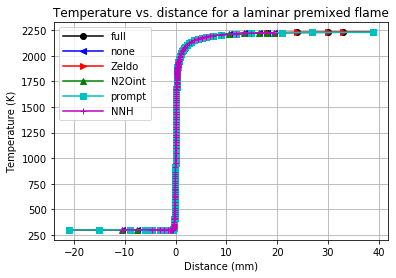

In [20]:
# plot steady-state temperature profiles, shifted to match temperatures at Tmatch
fig, ax = plt.subplots()
ax.plot((x_full-xm_full)*1000.,     T_full,   'k-o', label='full'  )
ax.plot((x_none-xm_none)*1000.,     T_none,   'b-<', label='none'  ) 
ax.plot((x_Zeldo-xm_Zeldo)*1000.,   T_Zeldo,  'r->', label='Zeldo' )
ax.plot((x_N2Oint-xm_N2Oint)*1000., T_N2Oint, 'g-^', label='N2Oint')
ax.plot((x_prompt-xm_prompt)*1000., T_prompt, 'c-s', label='prompt')
ax.plot((x_NNH-xm_NNH)*1000.,       T_NNH,    'm-+', label='NNH'   )
ax.set(xlabel='Distance (mm)',
       ylabel='Temperature (K)',
       title ='Temperature vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("T_vs_x_LPF_shifted.pdf")

Now all of the temperature profiles appear to be essentially the same. The NO chemistry does not have a significant influence on flame temperatures, as expected. One could proceed similarly to show that the computed major species profiles also are insensitive to the NO formation pathway that is considered, as expected.

Now let's look at NO:

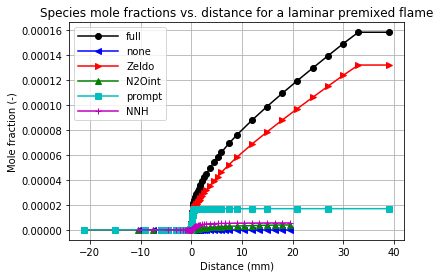

In [21]:
# plot steady-state NO mole-fraction profiles, shifted to match temperatures at Tmatch
fig, ax = plt.subplots()
ax.plot((x_full-xm_full)*1000.,     XNO_full,   'k-o', label='full'  )
ax.plot((x_none-xm_none)*1000.,     XNO_none,   'b-<', label='none'  ) 
ax.plot((x_Zeldo-xm_Zeldo)*1000.,   XNO_Zeldo,  'r->', label='Zeldo' )
ax.plot((x_N2Oint-xm_N2Oint)*1000., XNO_N2Oint, 'g-^', label='N2Oint')
ax.plot((x_prompt-xm_prompt)*1000., XNO_prompt, 'c-s', label='prompt')
ax.plot((x_NNH-xm_NNH)*1000.,       XNO_NNH,    'm-+', label='NNH'   )
ax.set(xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("NO_vs_x_LPF_shifted.pdf")

From these results, it can be seen that thermal NO from the extended Zeldovich mechanism dominates, and that the contribution from prompt (or Fenimore) NO is a distant second. The contributions from the $N_2O$-intermediate pathway and the NNH pathway are much smaller.

It also can be seen that thermal NO formation is slow, and continues well downstream of the main reaction zone on the products side, as we have discussed earlier. The computational grid for the "none", "N2Oint", and "NNH" cases do not extend as far downstream compared to those for "prompt", "Zeldo", and "full". The size of the computational grid is reflected in the computational time required for each case.

To see the "N2Oint", "prompt", and "NNH" cases more clearly, we replot without "full", "none", and "Zeldo":

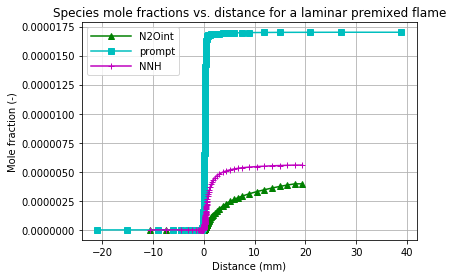

In [22]:
# plot shifted steady-state NO mole-fraction profiles without full and extended Zeldovich
fig, ax = plt.subplots()
#ax.plot((x_full-xm_full)*1000.,     XNO_full,   'k-o', label='full'  )
#ax.plot((x_none-xm_none)*1000.,     XNO_none,   'b-<', label='none'  ) 
#ax.plot((x_Zeldo-xm_Zeldo)*1000.,   XNO_Zeldo,  'r->', label='Zeldo' )
ax.plot((x_N2Oint-xm_N2Oint)*1000., XNO_N2Oint, 'g-^', label='N2Oint')
ax.plot((x_prompt-xm_prompt)*1000., XNO_prompt, 'c-s', label='prompt')
ax.plot((x_NNH-xm_NNH)*1000.,       XNO_NNH,    'm-+', label='NNH'   )
ax.set(xlabel='Distance (mm)',
       ylabel='Mole fraction (-)',
       title ='Species mole fractions vs. distance for a laminar premixed flame')
ax.grid(True)
ax.legend(handlelength=4,loc='best')
fig.savefig("NO_vs_x_LPF2_shifted.pdf")

It is clear that "prompt" NO is indeed formed promptly in the primary flame zone, as the name implies, while NO formation from the other mechanisms occurs downstream of the primary flame zone. In all case, the maximum NO is at the furthest downstream computed location in the flame.

The fraction of NO formed by each mechanism can then be determined as follows:

In [23]:
# access the number of grid points in each computed steady-state flame solution
n_full   = len(x_full)
n_none   = len(x_none)
n_Zeldo  = len(x_Zeldo)
n_N2Oint = len(x_N2Oint)
n_prompt = len(x_prompt)
n_NNH    = len(x_NNH)

# access the NO mole fraction at the furthest downstream grid point in each flame
NOmax_full   = XNO_full  [n_full  -1]
NOmax_none   = XNO_none  [n_none  -1]
NOmax_Zeldo  = XNO_Zeldo [n_Zeldo -1]
NOmax_N2Oint = XNO_N2Oint[n_N2Oint-1]
NOmax_prompt = XNO_prompt[n_prompt-1]
NOmax_NNH    = XNO_NNH   [n_NNH   -1]

# compute and print the fractions of the total NO formed through each pathway
frac_Zeldo  = NOmax_Zeldo  / NOmax_full
frac_N2Oint = NOmax_N2Oint / NOmax_full
frac_prompt = NOmax_prompt / NOmax_full
frac_NNH    = NOmax_NNH    / NOmax_full

frac_Zeldo , frac_N2Oint , frac_prompt , frac_NNH

(0.8340849098516679,
 0.02505775011229966,
 0.1074952777246206,
 0.03524794224586472)

The sum of these four fractions is very close to unity. 

From these results, it can be concluded that the approximate contributions of each pathway to NO formation in this flame are:

* ~83% for thermal NO (extended Zeldovich mechanism)

* ~11% for prompt NO (Fenimore mechanism)

* ~3.5% for the NNH pathway

* ~2.5% for the $N_2O$-intermediate pathway

As discussed in Chapter 15 of Turns 4th ed. and shown in Figure 15.2, the relative contribution of each pathway varies with the reactants composition, temperature, and pressure. Results from a modeling study of laminar premixed stochiometric $CH_4$-air flames over a wide range of pressures can be found in: M.C. Drake and R.J. Blint, "Calculations of NOx formation pathways in propagating, laminar, high pressure premixed $CH_4$/air flames," Combustion Science and Technology 75:261-285 (1991). The importance of superequilibrium O-atom concentrations on NO formation is discussed there. 

The results also can vary depending on the flame configuration that is considered. For example, the results shown in Figure 15.2 are for perfectly stirred reactors.